## Start measurments

In [1]:
#%matplotlib notebook
import os, time, sys
import importlib
import tables as tb
import matplotlib.pyplot as plt
import numpy as np
import panda2.panda2 as panda2

import panda2.analysis.fitfunctions as fitfunc
import panda2.scans.injection_scan as injection_scan
import panda2.scans.injection_scan_v2 as injection_scan_v2

# run "ping" command
!ping -c 1 192.168.10.16

# instancíate a Panda2 class
dut = panda2.Panda2()
# read yaml file and connect to FPGA
dut.init()
dut.set_sync(auto_sync=True)  ## do not delete this
plsgen = False

PING 192.168.10.16 (192.168.10.16) 56(84) bytes of data.
64 bytes from 192.168.10.16: icmp_seq=1 ttl=64 time=0.074 ms

--- 192.168.10.16 ping statistics ---
1 packets transmitted, 1 received, 0% packet loss, time 0ms
rtt min/avg/max/mdev = 0.074/0.074/0.074/0.000 ms


2024-07-05 08:00:22,595 - basil.HL.RegisterHardwareLayer - [INFO    ] (MainThread) Initializing spi_inj (firmware version: 2), module basil.HL.spi, base_addr 0x10
2024-07-05 08:00:22,596 - basil.HL.RegisterHardwareLayer - [INFO    ] (MainThread) Initializing inj (firmware version: 1), module panda2.pulse_gen_div, base_addr 0x100
2024-07-05 08:00:22,597 - basil.HL.RegisterHardwareLayer - [INFO    ] (MainThread) Initializing sync (firmware version: 3), module basil.HL.pulse_gen, base_addr 0x140
2024-07-05 08:00:22,599 - basil.HL.RegisterHardwareLayer - [INFO    ] (MainThread) Initializing gate (firmware version: 3), module basil.HL.pulse_gen, base_addr 0x180
2024-07-05 08:00:22,604 - basil.HL.RegisterHardwareLayer - [INFO    ] (MainThread) Initializing ts_inj (firmware version: 1), module panda2.timestamp_div, base_addr 0x1c0
2024-07-05 08:00:22,607 - basil.HL.RegisterHardwareLayer - [INFO    ] (MainThread) Initializing gpio (firmware version: 0), module basil.HL.gpio, base_addr 0x200
20

## Change settings (global, tdac, comp_en/dis etc)

### global configurations

In [3]:
# define col, row
col, row = 15, 5
### configure chip and enable injection
dut.set_en_inj([col, row])

# this is for Injection card

if plsgen:
    print('EXTERNAL PULSE GEN')
    att_factor = 10.
    plsgen.set_inj_amp(0.05*att_factor, low=0)
else:
    att_factor = 1.
    dut.set_inj_amp(0.05)

# set ampout ON
dut.set_en_ampout([col])
#dut.set_en_ampout([])


### inj_n: number of pulses to be injected. 0=continuous injection
# 1 = 1 clock of 40MHz = 25ns  inj_n= number of pulses to be injected, 0= inf
dut.set_inj(inj_n=1, inj_width=1024*8, inj_delay=1024*8, ext=True)
dut.inject()

#hui
## set all tdac to 0
#dut.set_tdac(7, comp='fast')
### slow comp
tdac1 = np.copy(dut.PixelConf['tdac1'])
dut.PixelConf['tdac1'][:,:]=0xFF
tdac1[:, :] = 7    # until 7
dut.set_tdac(tdac1, comp='slow')
VDACTh2=149 # 120v 165 176 used for tune (176 tuned scan) 166 later used 163 for 50v hv
#VDACTh2=250#150+26

##fast comp
tdac0 = np.copy(dut.PixelConf['tdac0'])
dut.PixelConf['tdac0'][:,:]=0xFF
tdac0[:, :] = 7   # until 7
dut.set_tdac(tdac0, comp='fast')
#VDACTh=250
VDACTh=161 #120v 179 ivan 195 (192 for tune all!!!, tuned scan 190) used for tune! 182 later user 178 for 50V hv

# sets VDAC and DAC
dut.set_conf(
             IPBigFine= 15,
             IPSmallFine= 23,
             VDACTh=VDACTh,  # fast comparator, 255= very high (alomost off)
             VDACTh2=VDACTh2, # slow comparator, ~128 =  a bit higher than VDACBL 
             VDACBL=102+26,  # base line ~100~128 
             VNComp=40, # default =40
             VNComp2=0,
             VN=32, 
             INFoll2=20,
             VNFoll=4, # std setting 2
             IPLoad2=4,#std setting 2
             hidrEnB=1,   #1 disalbe, 0 enalbe
             IBLRes=1,    # R of Bl
             IPDAC=50,   #50
             VNLVDS = 20,
             VNLVDSDel = 0,
             Invert = 1,
             VPDcl = 32,
             VNDcl = 32,
             IPFoll=10, # current for Ampout and HitBus defalt=10, OFF=0 (better for cross talk) 
                        # TDAC=7 no offset, TDAC=0 max negative offset
            )  ## set lowest (largest in number) threshold
            # IPDAC until 63
# sets comparator 
en_comp = np.copy(dut.PixelConf['en_comp0'])
### set all comp off
en_comp[:,:] = 1
en_comp[:,0] = 0
dut.set_en_comp(en_comp, comp='slow')
dut.set_en_comp(en_comp, comp='fast')
### set comp1 col=10, row=0 ON
en_comp[col, row] = 1
#hui
dut.set_en_comp(en_comp, comp='slow')
dut.set_en_comp(en_comp, comp='fast')
                #comp='slow')  ## 0= fast comp, 1 = slow

dut.set_en_hitbus([])

# set_sync: set SyncRes
dut.set_sync(auto_sync=True)


# set timestamp module ON
dut.set_ts_inj(True)

# set the data reciever ON
dut.set_rx(True)
# but mask data for this moment
dut['data_rx'].SAMPLING_EDGE=0
dut.mask_rx(True)


###############
#### Load slow and fast hui!!
#############
datdir = '/home/thirono/Nextcloud-kit/workspace/panda2-daq/tmp/output'


#3 columns tuned
#fname = os.path.join(datdir, '9pixels/tdacall_slowtune3cols_100624/results/tuned_tdac.npy')
#all columns tuned
fname = os.path.join(datdir, '9pixels/tdac_all_180624/results/tune_all_slow/tuned_tdac.npy')

print(fname)
tuned_tdac = np.load(fname)
dut.set_tdac(tuned_tdac, comp='slow')


#3 columns tuned
#fname2 = os.path.join(datdir, '9pixels/tdacall_fasttune3cols_090624//results/tuned_tdac.npy')
#all columns tuned
fname2 = os.path.join(datdir, '9pixels/tdac_all_180624/results/tune_all_fast_new/tuned_tdac.npy')



print(fname2)
tuned_tdac2 = np.load(fname2)
dut.set_tdac(tuned_tdac2, comp='fast')

2024-07-05 08:00:30,805 - root - [INFO    ] (MainThread) set_en_inj: en_injection_col=0x00008000 en_injection_row0=00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000 en_injection_row1=00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_10000_00000
2024-07-05 08:00:30,813 - root - [INFO    ] (MainThread) afg3252 set_amp high=0.500
2024-07-05 08:00:30,815 - root - [INFO    ] (MainThread) afg3252 set_amp low=0.000
2024-07-05 08:00:30,971 - root - [INFO    ] (MainThread) set_en_ampout: en_ampout_col=0x00008000
2024-07-05 08:00:30,985 - root - [INFO    ] (MainThread) _write_conf row0 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7]
2024-07-05 08:00:30,995 - root - [INFO    ] (MainThread) _write_conf row1 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7]
2024-07-05 08:0

EXTERNAL PULSE GEN


2024-07-05 08:00:31,012 - root - [INFO    ] (MainThread) _write_conf row3 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7]
2024-07-05 08:00:31,022 - root - [INFO    ] (MainThread) _write_conf row4 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7]
2024-07-05 08:00:31,030 - root - [INFO    ] (MainThread) _write_conf row5 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7]
2024-07-05 08:00:31,039 - root - [INFO    ] (MainThread) _write_conf row6 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7]
2024-07-05 08:00:31,055 - root - [INFO    ] (MainThread) _write_conf row7 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[7 7 7 7 7 7 7 7 7 7 7 7 

## Scurve scans

### check data rate (without source, data is noise) 

In [34]:
import panda2.analysis.interpreter as interpreter
dut.mask_rx(False)
time.sleep(1)
raw = dut.get_data_now()
print(len(raw), interpreter.raw2list(raw))
dut.mask_rx(True)

0 (array([],
      dtype=[('event_number', '<i8'), ('col', 'u1'), ('row', '<u2'), ('comp', 'u1'), ('ts11', '<u2'), ('ts12', '<u2'), ('ts2', '<u2'), ('ts3', 'u1'), ('timestamp', '<u2'), ('err', 'u1')]), array([],
      dtype=[('event_number', '<i8'), ('timestamp', '<i8'), ('err', 'u1')]))


#### source scan

2024-07-04 19:24:03,636 - root - [INFO    ] (MainThread) Initializing SourceScan
2024-07-04 19:24:03,637 - root - [INFO    ] (MainThread) Scan start time: 2024-07-04_19:24:03
2024-07-04 19:24:03,819 - root - [WARNING ] (MainThread) ScanBase.start:sender.init failed addr=tcp://127.0.0.1:6500
2024-07-04 19:24:03,965 - root - [INFO    ] (MainThread) Resetting Data-FIFO: size = 552
2024-07-04 19:24:04,166 - root - [WARNING ] (MainThread) Data-FIFO not empty after reset: size = 400
2024-07-04 19:24:04,267 - root - [INFO    ] (MainThread) Received words: 0
2024-07-04 19:24:04,268 - root - [INFO    ] (MainThread) Data queue size: 0
2024-07-04 19:24:04,269 - root - [INFO    ] (MainThread) SRAM FIFO size: 660
2024-07-04 19:24:04,270 - root - [INFO    ] (MainThread) Channel:                     CHIP_RX
2024-07-04 19:24:04,270 - root - [INFO    ] (MainThread) Discard counter:                0
2024-07-04 19:24:04,271 - root - [INFO    ] (MainThread) Starting FIFO readout...
2024-07-04 19:24:04,272

0.00s 5715/5715 hit=1143 ts=0


Text(0.5, 1.0, 'Fast')

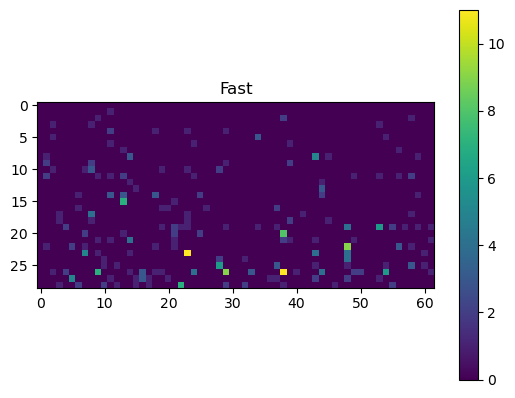

In [7]:

import panda2.scans.source_scan as source_scan
importlib.reload(source_scan)
scan = source_scan.SourceScan(dut=dut)
fraw = scan.start(scan_time=3600*3)
fhit = scan.analyze()


In [1]:
##### TODO TODO TODO TODO TODO TODO test this!!
with tb.open_file(fhit) as f:
    hit = f.root.hit_data[:]
hit0 = hit[hit['comp']==0]
fig, ax = plt.subplots(ncols=2)
map0 = np.zeros([panda2.NCOLS, panda2.NROWS])
for h in hit0:
    map0[h['col'], h['row']] = map0[h['col'], h['row']] + 1
ax[0].imshow(np.transpose(map0))
ax[0].colorbar()
ax[0].title('Fast')

hit1 = hit[hit['comp']==1]
map1 = np.zeros([panda2.NCOLS, panda2.NROWS])
for h in hit1:
    map1[h['col'], h['row']] = map1[h['col'], h['row']] +1
ax[1].imshow(np.transpose(map1))
ax[1].colorbar()
ax[1].title('Slow')

NameError: name 'tb' is not defined